## Data Collection

Main data collection is processed by running ['update.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/update.py) on a Flask ['server.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/server.py) scheduled through ngrok and Invictify.

This collection pipeline automatically updates the AWS MySQL RDS database with up-to-date channel statistics depending on the configured Invictify schedule.

In [20]:
from MySQL_DB_connect_functions import *
from MySQL_DB_update_functions import *
from youtube_api_functions import *

In [21]:
channel_id_list = ['UCIRYBXDze5krPDzAEOxFGVA'] #TheGuardian
channel_id_list = ['UCqnbDFdCpuN8CMEg0VuEBqA'] #NYTimes
channel_id_list = ['UCBi2mrWuNuyYy4gbM6fU18Q'] #ABCNews
channel_id_list = ['UCeY0bbntWzzVIaj2z3QigXg'] #NBCNews
channel_id_list = ['UCaXkIU1QidjPwiAYu6GcHjg'] #MSNBC

In [22]:
# Create Youtube Data API object & cleaned dataframe containing video data from selected channel using function from youtube_api_functions.py:
youtube_obj = build_yt_API_object() # builds Youtube API object
video_df = create_video_df(youtube_obj, channel_id_list, 500) # store API data into pandas df
processed_video_df = clean_video_df(video_df) # run df through cleaning function

In [23]:
selected_df = processed_video_df.query('viewCount > 5000 & commentCount > 500')

In [24]:
video_ids = list(selected_df['video_id'])

In [25]:
all_comments_df = pd.DataFrame()
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    all_comments_df = all_comments_df.append(comment_data, ignore_index=True)

In [26]:
all_comments_df.head()

,video_id,comment_id,comment,date
0,Wzj_3AXnkxA,UgxM_oll5lyc91c2lAh4AaABAg,"To quote ""Blazing Saddles,"" ""I don't care if i...",2022-09-19T23:46:02Z
1,Wzj_3AXnkxA,UgzhzrWXis_J18fe1Jh4AaABAg,I studied the psychology and sociology of reli...,2022-09-19T23:45:54Z
2,Wzj_3AXnkxA,UgwfBTDd6vJkmkkHOSJ4AaABAg,They are coming... !!!,2022-09-19T23:45:43Z
3,Wzj_3AXnkxA,Ugzbp6h1S7LmEmbzhkJ4AaABAg,"it is incredibly sad, that in 2022, words like...",2022-09-19T23:45:38Z
4,Wzj_3AXnkxA,UgyhZbMskCy0jLDB4kl4AaABAg,"Hmmm, where have I seen this type of gesturing...",2022-09-19T23:45:28Z


In [27]:
all_comments_df['comment'][3]

'it is incredibly sad, that in 2022, words like god carry any weight outside of history books. America is grossly uneducated.'

## Comment Data Cleaning

In [28]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [29]:
def preprocess(comment):
    comment = comment.str.replace("\n", " ") # remove new lines 
    return comment

all_comments_df['comment'] = preprocess(all_comments_df['comment'])

In [30]:
all_comments_df

,video_id,comment_id,comment,date
0,Wzj_3AXnkxA,UgxM_oll5lyc91c2lAh4AaABAg,"To quote ""Blazing Saddles,"" ""I don't care if i...",2022-09-19T23:46:02Z
1,Wzj_3AXnkxA,UgzhzrWXis_J18fe1Jh4AaABAg,I studied the psychology and sociology of reli...,2022-09-19T23:45:54Z
2,Wzj_3AXnkxA,UgwfBTDd6vJkmkkHOSJ4AaABAg,They are coming... !!!,2022-09-19T23:45:43Z
3,Wzj_3AXnkxA,Ugzbp6h1S7LmEmbzhkJ4AaABAg,"it is incredibly sad, that in 2022, words like...",2022-09-19T23:45:38Z
4,Wzj_3AXnkxA,UgyhZbMskCy0jLDB4kl4AaABAg,"Hmmm, where have I seen this type of gesturing...",2022-09-19T23:45:28Z
...,...,...,...,...
28294,py3Mrsl9ZDs,UgxStdCgCXo-eaOkMI14AaABAg,"Even in the earliest surgical abortions, the u...",2022-09-07T15:42:29Z
28295,py3Mrsl9ZDs,Ugwi_5DgwG7DXu_5Jdd4AaABAg,"Alito screwed the Republicans..., When his rea...",2022-09-07T15:11:10Z
28296,py3Mrsl9ZDs,Ugy3Z6A2KzsJi2btK854AaABAg,No more Viagra until this is changed back.,2022-09-07T15:07:00Z
28297,py3Mrsl9ZDs,UgxCn4NxmpzkEr8lP7d4AaABAg,"gee, why doesn't the anchor's just go ahead an...",2022-09-07T15:00:20Z


In [31]:
all_comments_df['comment'][3]

'it is incredibly sad, that in 2022, words like god carry any weight outside of history books. America is grossly uneducated.'

## Visualizing Data

In [32]:
all_comments_df['vader_sentiment'] = all_comments_df.comment.apply(lambda x: sia.polarity_scores(x))
all_comments_df['vader_comp_sentiment'] = all_comments_df.vader_sentiment.apply(lambda x: x['compound'])

In [33]:
video_comp_sentiments = pd.DataFrame(columns=['video_id', 'vid_title', 'avg_comp_sentiment', 'vid_viewcount'])
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    comment_data['vader_sentiment'] = comment_data.comment.apply(lambda x: sia.polarity_scores(x))
    comment_data['vader_comp_sentiment'] = comment_data.vader_sentiment.apply(lambda x: x['compound'])
    comp_mean = comment_data['vader_comp_sentiment'].mean()

    vid_title = processed_video_df.loc[processed_video_df['video_id'] == video, 'title'].item()
    vid_viewcount = processed_video_df.loc[processed_video_df['video_id'] == video, 'viewCount'].item()
    vid_likecount = processed_video_df.loc[processed_video_df['video_id'] == video, 'likeCount'].item()

    dict = {'video_id': video,
            'vid_title': vid_title,
            'avg_comp_sentiment': comp_mean,
            'vid_viewcount': vid_viewcount,
            'vid_likecount': vid_likecount
            }

    video_comp_sentiments = video_comp_sentiments.append(dict, ignore_index=True)
    

In [34]:
video_comp_sentiments

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,Wzj_3AXnkxA,Frank Figliuzzi Calls Trump’s QAnon Embrace ‘T...,-0.126828,102170,3087.0
1,gI0EUto-kHY,Calls For Criminal Investigation After 'Manipu...,-0.149117,12230,626.0
2,OKwvAOTQhyo,House To Vote On Bipartisan Elections Bill To ...,-0.045120,56552,1896.0
3,Y9m5K14fznI,President Biden Seeks To Restore Trust In Amer...,-0.012002,18010,553.0
4,dZH8nmiXEsY,"Political Theater, “Candidate Quality” Signal ...",-0.133548,48864,1248.0
...,...,...,...,...,...
280,J3aFouEaSI0,Trump's Remaking Of Judiciary Appears To Pay O...,-0.020421,537302,8364.0
281,Q1Fv8fD1ku0,Trump's Pledged 1/6 Pardons Showcase Embrace O...,-0.011090,41520,1054.0
282,ELJ7cO3Qm-0,Trump Will 'Do Anything For His Own Political ...,-0.002916,155263,3253.0
283,679s2pQHlso,Joyce Vance 'Profoundly Sad' About Trump Being...,-0.035182,370015,8567.0


In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

The interactive graph displaying video information hover text can be 

In [36]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score"
    # legend_title="Legend Title"
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='vscode')

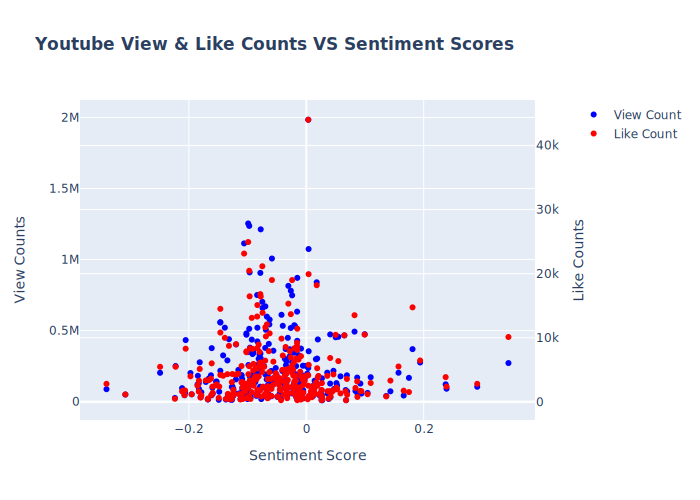

In [37]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score"
    # legend_title="Legend Title"
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='svg')